<a href="https://colab.research.google.com/github/RutulPatel007/VR_Project1_Rutul_Patel_IMT2022021/blob/main/VR_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z/view" -O MSFD.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z
From (redirected): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&confirm=t&uuid=e0f0fb60-4cb1-4a8e-b7c9-4490254e06d7
To: /content/MSFD.zip
100% 2.25G/2.25G [00:20<00:00, 111MB/s]


In [ ]:
import zipfile

file_path = "MSFD.zip"

if zipfile.is_zipfile(file_path):
    print("Valid ZIP file.")
else:
    print("Not a ZIP file. Check the download.")

Valid ZIP file.


In [ ]:
!unzip MSFD.zip

Streaming output truncated to the last 5000 lines.
  inflating: MSFD/1/img/006604.jpg   
  inflating: MSFD/1/img/006605.jpg   
  inflating: MSFD/1/img/006606.jpg   
  inflating: MSFD/1/img/006607.jpg   
  inflating: MSFD/1/img/006608.jpg   
  inflating: MSFD/1/img/006609.jpg   
  inflating: MSFD/1/img/006610.jpg   
  inflating: MSFD/1/img/006611.jpg   
  inflating: MSFD/1/img/006612.jpg   
  inflating: MSFD/1/img/006613.jpg   
  inflating: MSFD/1/img/006614.jpg   
  inflating: MSFD/1/img/006615.jpg   
  inflating: MSFD/1/img/006616.jpg   
  inflating: MSFD/1/img/006617.jpg   
  inflating: MSFD/1/img/006618.jpg   
  inflating: MSFD/1/img/006619.jpg   
  inflating: MSFD/1/img/006620.jpg   
  inflating: MSFD/1/img/006621.jpg   
  inflating: MSFD/1/img/006622.jpg   
  inflating: MSFD/1/img/006623.jpg   
  inflating: MSFD/1/img/006624.jpg   
  inflating: MSFD/1/img/006625.jpg   
  inflating: MSFD/1/img/006626.jpg   
  inflating: MSFD/1/img/006627.jpg   
  inflating: MSFD/1/img/006628.jpg   

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

In [ ]:
# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 8
EPOCHS = 50

# Path to dataset
IMAGE_DIR = "/content/MSFD/1/face_crop"
MASK_DIR = "/content/MSFD/1/face_crop_segmentation"

In [ ]:
# Load images and masks
def load_data(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))  # Ensure correct order
    mask_files = sorted(os.listdir(mask_dir))

    count = 0

    for img_file, mask_file in zip(image_files, mask_files):
        if(count>=1000):
            break
        # Read and resize images
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, img_size) / 255.0  # Normalize

        # Read and resize masks
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Convert to binary (0 or 1)

        images.append(img)
        masks.append(mask)
        count+=1
    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(IMAGE_DIR, MASK_DIR)
print(f"Dataset loaded: {X.shape}, {Y.shape}")

Dataset loaded: (1000, 256, 256, 3), (1000, 256, 256, 1)


In [ ]:
# Split dataset (80% Train, 20% Validation)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define U-Net Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def unet(input_shape=(256, 256, 3), dropout_rate=0.3):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(dropout_rate)(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(dropout_rate)(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(dropout_rate)(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(dropout_rate)(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(dropout_rate)(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Metrics
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

# Compile Model
model = unet()
model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy", iou_metric, dice_metric])

# Train Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

# Save Model
model.save("unet_mask_segmentation.h5")

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load trained U-Net model
model = load_model("/content/unet_mask_segmentation.h5",
                   custom_objects={'iou_metric': iou_metric})

# Function to preprocess input image
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to predict mask
def predict_mask(image_path, output_path="output_mask.png"):
    input_image = preprocess_image(image_path)
    predicted_mask = model.predict(input_image)[0]  # Remove batch dimension

    # Convert to binary mask (threshold = 0.5)
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255

    # Save the mask
    cv2.imwrite(output_path, binary_mask)
    print(f"Mask saved to {output_path}")

# Example usage
if __name__ == "__main__":
    image_path = "/content/MSFD/1/face_crop/000017_1.jpg"  # Replace with your image path
    predict_mask(image_path)


OSError: Unable to synchronously open file (file signature not found)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


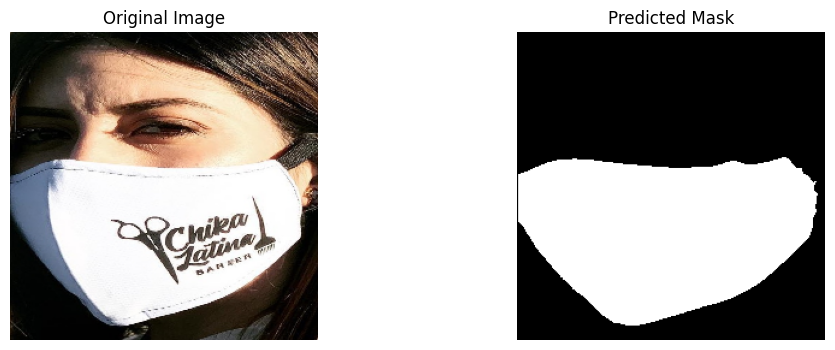

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Define image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Load trained model
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

model = load_model("unet_mask_segmentation.h5", custom_objects={'iou_metric': iou_metric, 'dice_metric': dice_metric})

# Function to preprocess input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0  # Resize and normalize
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to make predictions
def predict_mask(image_path):
    img = preprocess_image(image_path)
    mask_pred = model.predict(img)[0]  # Remove batch dimension
    mask_pred = (mask_pred > 0.5).astype(np.uint8)  # Threshold mask
    return mask_pred

# Function to visualize results
def visualize_results(image_path, mask_pred):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(img_resized)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(mask_pred, cmap="gray")
    ax[1].set_title("Predicted Mask")
    ax[1].axis("off")



    plt.show()

# Test on an image
TEST_IMAGE = "/content/MSFD/1/face_crop/000099_1.jpg"  # Change this to your test image path
if os.path.exists(TEST_IMAGE):
    mask_prediction = predict_mask(TEST_IMAGE)
    visualize_results(TEST_IMAGE, mask_prediction)
else:
    print(f"Test image '{TEST_IMAGE}' not found. Please check the path.")